In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
package_dir = "../input/pretrained-models.pytorch-master/"
sys.path.insert(0, package_dir)
import pretrainedmodels
package_dir = '../input/early-stopping-pytorch'
sys.path.append(package_dir)
from pytorchtools import EarlyStopping
from PIL import Image
import numpy as np
import pandas as pd
import scipy as sp
from functools import partial
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import seaborn as sns
from collections import Counter, OrderedDict
import json
import math
import numbers
import time
import cv2
import gc
import torchvision
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import os
from pynverse import inversefunc

IMG_SIZE = 256

# To have reproducible results and compare them
seedValue = 2019
np.random.seed(seedValue)
torch.manual_seed(seedValue)
os.environ['PYTHONHASHSEED'] = str(seedValue)
torch.cuda.manual_seed(seedValue)
torch.cuda.manual_seed_all(seedValue) 
#torch.backends.cudnn.deterministic = True  
#torch.backends.cudnn.benchmark = False

# Specify GPU usage
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5" 
device_ids = [0,1]
device = torch.device("cuda:0")

def quadratic_kappa(y_hat, y, coef):
    for pred in enumerate(y_hat):
            if pred[1] < coef[0]:
                y_hat[1] = 0
            elif pred[1] >= coef[0] and pred[1] < coef[1]:
                y_hat[1] = 1
            elif pred[1] >= coef[1] and pred[1] < coef[2]:
                y_hat[1] = 2
            elif pred[1] >= coef[2] and pred[1] < coef[3]:
                y_hat[1] = 3
            else:
                y_hat[1] = 4
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device=device)

# confusion matrix
def plot_cmx(true, output):
    labels = [0,1,2,3,4]
    cmx = confusion_matrix(true, output,labels=labels)
    plt.figure(figsize=(6,4)) 
    plt.title("Confusion Matrix")
    sns.heatmap(cmx, annot = True)
    plt.show()
    
# calculate scale from ratio
inv = inversefunc(lambda x : (np.arcsin(2*x**2-1)+2*x*np.sqrt(1-x**2))/(2*x**2),domain=[0.7,1.0])

# pre-processing

In [4]:
def crop_image1(img,tol=7):
    # 'tol' is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        
        return img
    
def crop_out_black(img):
    height, width = img.shape[1:]
    black = img[:, :int(height/20), :int(width/20)].mean(dim=(1, 2))
    rowmeans = img.mean(dim=1)
    linemeans = img.mean(dim=2)
    nonblack_rows = ((rowmeans - black[:, None]).max(dim=0)[0] > .02).nonzero()
    nonblack_lines = ((linemeans - black[:, None]).max(dim=0)[0] > .02).nonzero()
    try:
        left, right = nonblack_rows[0].item(), nonblack_rows[-1].item()
        upper, lower = nonblack_lines[0].item(), nonblack_lines[-1].item()
        img = img[:, upper:lower, left:right]
    except:
        print('crop out black didnt work')
    return img

def center(img):
    # crop such that the center of mass of non-black pixels is roughly in the center
    _, height, width = img.shape
    shapified = shapify_torch(img)[0, ...] #just take one of 3 channels
    nonzero = (shapified).nonzero().to(torch.float)
    center = nonzero.mean(dim = 0).to(torch.int)
    if center[0] > height/2: #center too low, crop from top
        new_height = 2 * (height - center[0])
        img = img[:, -new_height:, :]
    else: #center too high, crop from bottom
        new_height = 2 * center[0]
        img = img[:, :new_height, :]
    if center[1] > width/2: #center too far right, crop from left
        new_width = 2*(width- center[1])
        img = img[:, :, -new_width:]
    else: #center too far left, crop from right
        new_width = 2*center[1]
        img = img[:, :, :new_width]
    return img

def tight_crop(img): #assumes black cropped out and centered
    shapified = shapify_torch(img)[0, ...]
    if shapified.to(torch.float).mean() > .95: #already tight crop
        #print('already tight crop, passing')
        return img
    width = img.shape[2]
    width_margin = int(.06 * width)
    img = img[:, :, width_margin:-width_margin]
    shapified = shapified[ :, width_margin:-width_margin]
    num_white_per_line = shapified.sum(dim=1) / shapified.shape[1]
    white_above_threshold = (num_white_per_line > .9).nonzero()
    try:
        upper, lower = white_above_threshold[0], white_above_threshold[-1]
    except:
        # image is too dark so that we crop out everything,
        upper , lower = 0, img.shape[1]
    img = img[:, upper:lower, :]
    return img

def shapify_torch(img_data):
    height, width = img_data.shape[1:]
    black = img_data[:, :int(height/20), :int(width/20)].mean(dim=(1, 2)) # get average r, g, b of top-left corner as an estimate for black value
    mask = ((img_data - black[:, None, None]).max(dim = 0)[0] > .02).to(img_data.dtype) #note torch's max with argument dim returns (max, argmax)
    return torch.stack((mask, mask, mask))

to_256_torch = lambda img: torch.nn.functional.interpolate(img[None, ...], size = (256,256), 
                                                           mode='bilinear', align_corners = False)[0, ...]

def remove_corners(img): #blacken a triangle of 1/6 at each corner. assumes square input
    corner_size = img.shape[1]//6
    mask = torch.ones( (corner_size, corner_size )).triu()
    img[:, :corner_size, :corner_size] *= mask.flip(dims=(0,))[None, :, :]
    img[:, :corner_size, -corner_size:] *= mask.flip(dims=(0,1))[None, :, :]
    img[:, -corner_size:, :corner_size] *= mask[None, :, :]
    img[:, -corner_size:, -corner_size:] *= mask.flip(dims=(1,))[None, :, :]
    return(img)

def gaussian_blur(img, radius=None, rel_size = None):
    if radius is None:
        radius = int(rel_size * img.shape[1])
    if radius % 2 == 0:
        radius = radius + 1
    img_numpy = img.permute(1, 2, 0).numpy()
    img_numpy = cv2.GaussianBlur(img_numpy,(radius,radius),0)
    img = torch.Tensor(img_numpy).permute(2, 0, 1)
    return img

def subtract_gaussian_blur(img, rel_size = .2, color_scale = 1):
    img_blurred = gaussian_blur(img, rel_size = rel_size)
    img = (4*color_scale*(img - img_blurred)).sigmoid() #sigmoid to squish to [0, 1]. Factor 4 because the slope of sigmoid at 0 is 4.
    return img


In [5]:
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, transform, datatype='train', mixup_prob=0):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.datatype = datatype
        self.mixup_prob = mixup_prob

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # mixup is valid in datasets of 2015 or 2019 train
        if self.datatype == 'test':
            self.mixup_prob = 0
            
        # Whether to mixup or not is chosen with probability p
        is_mixup = bool(np.random.binomial(n=1, p=self.mixup_prob)) 
        
        # 画像データの読み込み
        if self.datatype=='train':
            img_name = os.path.join('../input/aptos2019-blindness-detection/train_images',
                                self.data.loc[idx, 'id_code'] + '.png')
            label = self.data.loc[idx, 'diagnosis']
            if is_mixup:
                label2 = self.adj_label(label)
                img_id2 = self.data[self.data['diagnosis']==label2].sample(1).iloc[0]['id_code']
                img_name2 = os.path.join('../input/aptos2019-blindness-detection/train_images',img_id2 + '.png')
        elif self.datatype=='train_old':
            img_name = os.path.join('../input/diabetic-retinopathy-resized/resized_train',
                                self.data.loc[idx, 'image'] + '.jpeg')
            label = self.data.loc[idx, 'level']
            if is_mixup:
                label2 = self.adj_label(label)
                img_id2 = self.data[self.data['level']==label2].sample(1).iloc[0]['image']
                img_name2 = os.path.join('../input/diabetic-retinopathy-resized/resized_train',img_id2 + '.jpeg')
        else:
            img_name =  os.path.join('../input/aptos2019-blindness-detection/test_images',
                                     self.data.loc[idx, 'id_code'] + '.png')
        # image preprocessing
        img = self.image_process(img_name)
        
        # mix up two adjacent labeled images with probability mixup_prob
        if is_mixup:
            img2 = self.image_process(img_name2)
            img = (img + img2['image']) / 2
            label = (label + label2)/2 + np.random.normal(loc=0.0, scale=0.1**2)
            
        # batch must be a sequence of the same dtype,
        # so all labels are float if mixup_prob is larger than 0.
        if not self.datatype=='test':
            if self.mixup_prob > 0:
                label = torch.as_tensor(float(label))
            else:
                label = torch.as_tensor(int(label))
       
        if self.datatype=='train':
            return {'image': img,
                    'labels': label
                    }
        elif self.datatype=='train_old':
            return {'image': img,
                    'labels': label
                    }
        else:
            return {'image': img}
        
    def image_process(self,img_name):
        img = Image.open(img_name)
        #img = transforms.ToPILImage()(img)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)
        
        return img
    
    # 隣接したラベルを返すmixup用の関数
    # 例えば入力が0なら1を，2なら1or3を返す．
    def adj_label(self,l):
        res = l - 1 + 2* np.random.randint(2)
        if res == -1:
            res = 1
        elif res == 5:
            res = 3
        return res
    

In [6]:
transform = torchvision.transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4,contrast=(0.9,1.4),saturation=0.4),
    transforms.ToTensor(),
    crop_out_black, 
    center, 
    tight_crop, 
    to_256_torch, 
    remove_corners, 
    lambda img: subtract_gaussian_blur(img, rel_size=.2, color_scale=1), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

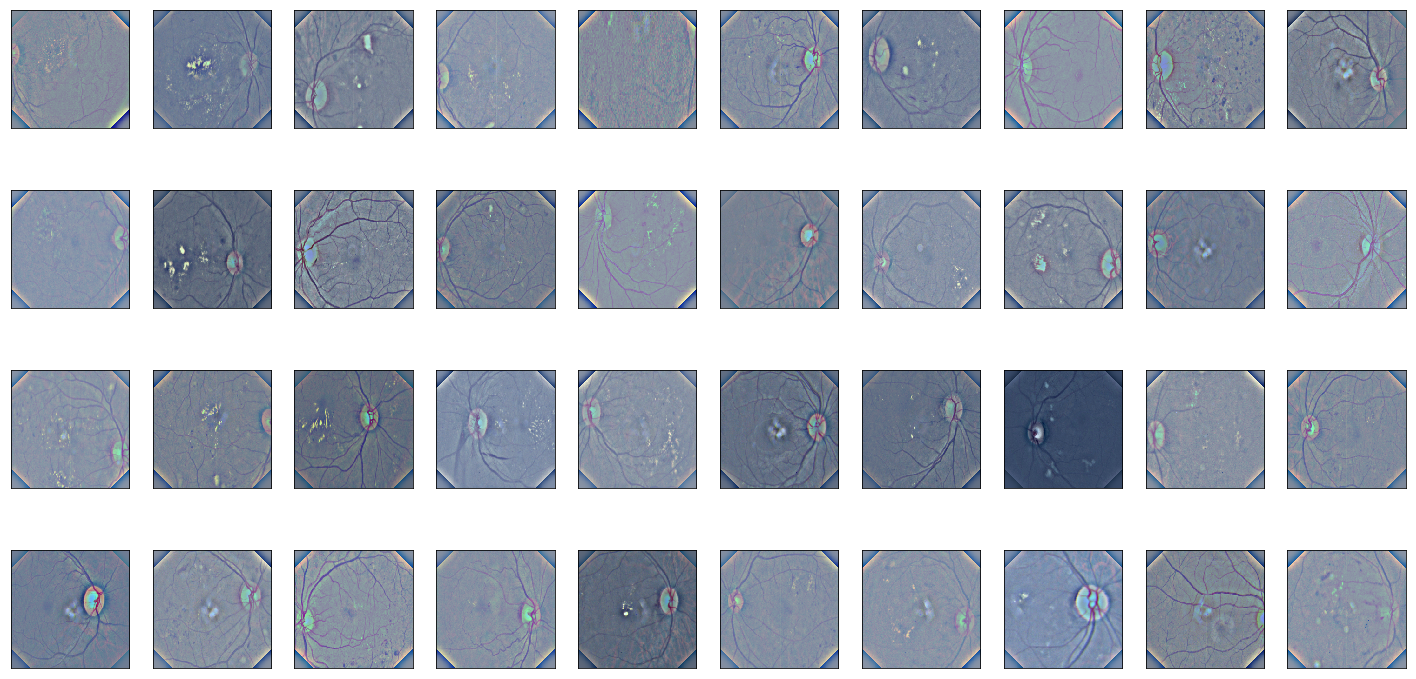

In [8]:
PLOT = True
if PLOT:
    rows = 4
    cols = 10
    data_dic = {
                'train':{'csv':'../input/aptos2019-blindness-detection/train.csv','datatype':'train'},
                'test':{'csv':'../input/aptos2019-blindness-detection/test.csv','datatype':'test'},
                '2015':{'csv':'../input/diabetic-retinopathy-resized/new_trainLabels.csv','datatype':'train_old'},      
               }
    select = 'test'
    sample_dataset = RetinopathyDataset(csv_file=data_dic[select]['csv'],
                                        transform=transform, datatype=data_dic[select]['datatype'], mixup_prob=0)

    fig = plt.figure(figsize=(25, 16))
    for i in range(rows):
        for j in range(cols):
            ax = fig.add_subplot(5, 10, i * cols + j + 1, xticks=[], yticks=[])
            data = sample_dataset.__getitem__(cols*i+j)
            im =  data['image'].permute(1,2,0).numpy()
            im = (im - np.amin(im)) / (np.amax(im) - np.amin(im)) *255
            plt.imshow(im.astype(np.uint8))
            if not select == 'test':
                label = data['labels'].numpy()
                ax.set_title('Label: {0:.2f}'.format(label))
            if 10*i+j == 39:
                break


In [2]:
def load_model_instagram():    
    model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x16d_wsl')
    for param in model.parameters():
            param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.fc = nn.Sequential(
                          nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                          nn.Dropout(p=0.25),
                          nn.Linear(in_features=2048, out_features=2048, bias=True),
                          nn.ReLU(),
                          nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                          nn.Dropout(p=0.5),
                          nn.Linear(in_features=2048, out_features=1, bias=True),
                         )
    
    return model

def load_model_imagenet(pretrained='imagenet'):
    class Net(nn.Module):
        def __init__(self, model):
            super(Net, self).__init__()
            for param in model.parameters():
                    param.requires_grad = False
            model.avgpool = nn.AdaptiveAvgPool2d(1)
            model.last_linear = nn.Sequential(
                                              nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                              nn.Dropout(p=0.25),
                                              nn.Linear(in_features=2048, out_features=2048, bias=True),
                                              nn.ReLU(),
                                              nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                              nn.Dropout(p=0.5),
                                              nn.Linear(in_features=2048, out_features=1, bias=True),
                                             )
            self.l1 = nn.Sequential(*list(model.children())[:-1]).to('cuda:0')
            self.last = list(model.children())[-1]

        def forward(self, x):
            x = self.l1(x)
            x = x.view(x.size()[0], -1)
            x = self.last(x)
            return x

    model = Net(pretrainedmodels.__dict__['resnet50'](pretrained=pretrained))
    return model

# train

In [9]:
class train(object):
    def __init__(self, params):
        # params
        self.lr = params.get('lr')
        self.bs = params.get('batch_size')
        self.n_epochs = params.get('n_epochs')
        self.n_freeze = params.get('n_freeze')
        self.coef = params.get('coef')
        self.criterion = params.get('criterion')
        self.num_workers = params.get('num_workers')
        self.load_state = params.get('load_state')
        self.load_path = params.get('load_path')
        self.save_path = params.get('save_path')
        self.device = params.get('device')
        self.n_folds = params.get('n_folds')
        self.use_valid = False
        self.early_stop = params.get("early_stop")
        self.patience = params.get("patience")
        self.finetune = params.get("finetune")
        self.mixup_prob = params.get('mixup_prob')
        self.is_mixup = bool(self.mixup_prob)
    
    def get_train(self,data):
        self.train_data = data
        
    def get_valid(self,data):
        self.valid_data = data
        self.use_valid = True
    
    def fit(self, use_cv=False, train_idx=None, valid_idx=None):
        since = time.time()
        # Model
        if self.load_state:
            model = load_model_imagenet(pretrained='imagenet')
            
            # load params
            if torch.cuda.device_count() > 1: # multi GPUs
                state_dict = torch.load(self.load_path)
                new_state_dict = OrderedDict()
                for k, v in state_dict.items():
                    name = k[7:] # remove `module.`
                    new_state_dict[name] = v
                model.load_state_dict(new_state_dict)
            else:    
                model.load_state_dict(torch.load(self.load_path, map_location=self.device))
        else: # single GPU
            model = load_model_imagenet(pretrained='imagenet')
            
        if torch.cuda.device_count() > 1: # train in parallel if multi GPUs available
            model = nn.DataParallel(model, device_ids)
        model = model.to(device)

        # Set learning rate by layer, if you like
        if torch.cuda.device_count() > 1: # multi GPUs 
            plist = [
                     {'params': model.module.last.parameters(), 'lr': 1e-3}
                    ]
        else: # single GPU
            plist = [
                    {'params': model.last.parameters(), 'lr': 1e-3}
                    ]

        
        optimizer = optim.Adam(plist, lr=self.lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5)
        
        if use_cv: # if you choose cv, split the data into train and valid
            train_sampler = SubsetRandomSampler(train_idx)
            valid_sampler = SubsetRandomSampler(valid_idx)
            data_loader_train = torch.utils.data.DataLoader(self.train_data, batch_size=self.bs,
                                                num_workers=self.num_workers,sampler=train_sampler)
            data_loader_valid = torch.utils.data.DataLoader(self.train_data, batch_size=self.bs,
                                                num_workers=self.num_workers,sampler=valid_sampler)
            
        # prepare train and valid data (e.g. train: 2015, valid: 2019)
        elif self.use_valid:
            data_loader_train = torch.utils.data.DataLoader(self.train_data, batch_size=self.bs,
                                                num_workers=self.num_workers)
            data_loader_valid = torch.utils.data.DataLoader(self.valid_data, batch_size=self.bs,
                                                num_workers=self.num_workers)
        else: # no validation
            data_loader_train = torch.utils.data.DataLoader(self.train_data, batch_size=self.bs,
                                                num_workers=self.num_workers)
            
        if self.early_stop: 
            early_stopping = EarlyStopping(patience=self.patience, verbose=True)
        
        for epoch in range(self.n_epochs):
            # unfreeze layers if you like
            if epoch == self.n_freeze and not self.finetune:
                if torch.cuda.device_count() > 1: # multi GPUs
                    for param in model.module.parameters():
                        param.requires_grad = True
                else: # single GPU
                    for param in model.parameters():
                        param.requires_grad = True

            print('Epoch {}/{}'.format(epoch, self.n_epochs - 1))
            print('-' * 10)
            scheduler.step()
            model.train()
            running_loss = 0.0
            kappa = 0
            steps = 0
            with tqdm(data_loader_train, total=int(len(data_loader_train))) as pbar:
                for bi, d in enumerate(pbar):
                    inputs = d["image"]
                    labels = d["labels"].view(-1, 1)
                    inputs = inputs.to(self.device, dtype=torch.float)
                    labels = labels.to(self.device, dtype=torch.float)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        loss =  torch.sqrt(self.criterion(outputs, labels)) #RMSE
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.mean().item() 
                    y_hat = torch.Tensor.cpu(outputs.view(-1)).detach()
                    y = torch.Tensor.cpu(labels.view(-1)).detach()
                    # kappa is invalid if you use float labels
                    if not self.is_mixup:
                        kappa += quadratic_kappa(y_hat, y, self.coef).mean().item()
                    steps += 1
                    pbar.set_postfix(OrderedDict(rmse_loss = running_loss / steps,
                                                 kappa_score = kappa / steps))
                    
            epoch_loss = running_loss / steps
            print('Training Loss: {:.4f}'.format(epoch_loss))
            # calculate kappa score only to monitor training
            kappa = kappa / steps
            print('Training Kappa: {:.4f}'.format(kappa))
            
            if self.use_valid or use_cv:
                model.eval()
                running_loss = 0.0
                kappa = 0
                steps = 0
                true = np.zeros((len(self.valid_data), 1)) if not use_cv else np.zeros((len(valid_sampler), 1))
                preds = np.zeros((len(self.valid_data), 1)) if not use_cv else np.zeros((len(valid_sampler), 1))

                with tqdm(data_loader_valid , total=int(len(data_loader_valid))) as pbar:
                    for step, batch in enumerate(pbar):
                        inputs = batch["image"]
                        labels = batch["labels"].view(-1, 1)
                        inputs = inputs.to(self.device, dtype=torch.float)
                        labels = labels.to(self.device, dtype=torch.float)

                        with torch.no_grad():
                            outputs = model(inputs)
                            loss =  torch.sqrt(self.criterion(outputs, labels)) #RMSE

                        running_loss += loss.mean().item()     
                        y_hat = torch.Tensor.cpu(outputs.view(-1))
                        y = torch.Tensor.cpu(labels.view(-1))
                        # kappa is invalid if you use float labels
                        if not self.is_mixup: 
                            true[step * self.bs:(step + 1) * self.bs] += labels.detach().cpu().squeeze().numpy().ravel().reshape(-1, 1)
                            preds[step * self.bs:(step + 1) * self.bs] += outputs.detach().cpu().squeeze().numpy().ravel().reshape(-1, 1)
                            kappa += quadratic_kappa(y_hat, y, self.coef).mean().item()
                        steps += 1
                        pbar.set_postfix(OrderedDict(rmse_loss = running_loss / steps,
                                                     kappa_score = kappa / steps))
                        
                epoch_loss = running_loss / steps
                print('Validation Loss: {:.4f}'.format(epoch_loss))
                # calculate kappa score only to monitor training
                kappa = kappa / steps
                print('Validation Kappa: {:.4f}'.format(kappa))
                plot_cmx(true.astype(int),preds.astype(int))
                
                # early stopping
                if self.early_stop:
                    eval_loss = epoch_loss
                    early_stopping(eval_loss, model)
                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
        # save model except when cv
        if not use_cv:
            torch.save(model.state_dict(), self.save_path)

        del(model, data_loader_train)
        gc.collect()
        torch.cuda.empty_cache() 
        
    def cv(self): # cross validation
        num_train = len(self.train_data)
        indices = list(range(num_train))
        kf = KFold(n_splits=self.n_folds, random_state=1337, shuffle=True)

        train_idx = []
        valid_idx = []

        for t, v in kf.split(indices):
            train_idx.append(t)
            valid_idx.append(v)

        # Training                        
        for fold in np.arange(self.n_folds):
            print('Fold:',fold)
            self.fit(use_cv=True,train_idx=train_idx[fold],valid_idx=valid_idx[fold])

Epoch 0/39
----------



Training Loss: 0.9372
Training Kappa: 0.2233



Validation Loss: 0.9311
Validation Kappa: 0.6118


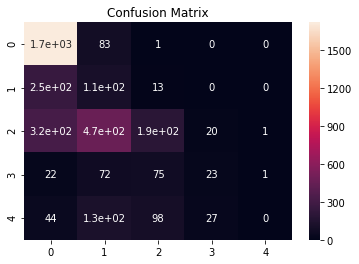

Validation loss decreased (inf --> 0.931144).  Saving model ...
Epoch 1/39
----------



Training Loss: 0.9017
Training Kappa: 0.2534



Validation Loss: 0.9110
Validation Kappa: 0.6308


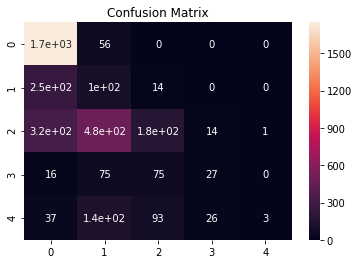

Validation loss decreased (0.931144 --> 0.910951).  Saving model ...
Epoch 2/39
----------



Training Loss: 0.8898
Training Kappa: 0.2786



Validation Loss: 0.8928
Validation Kappa: 0.6522


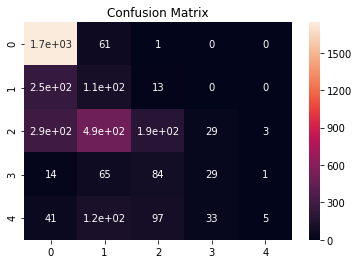

Validation loss decreased (0.910951 --> 0.892789).  Saving model ...
Epoch 3/39
----------



Training Loss: 0.8804
Training Kappa: 0.2871



Validation Loss: 0.8946
Validation Kappa: 0.6705


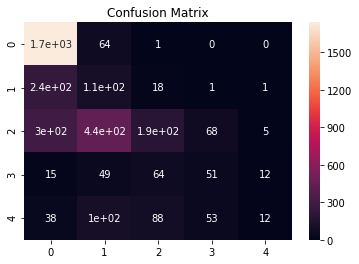

EarlyStopping counter: 1 out of 4
Epoch 4/39
----------



Training Loss: 0.8505
Training Kappa: 0.3251



Validation Loss: 0.9066
Validation Kappa: 0.6473


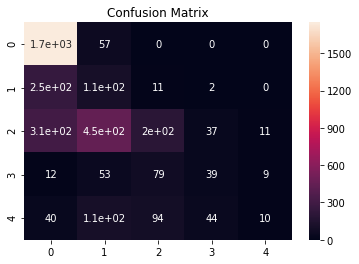

EarlyStopping counter: 2 out of 4
Epoch 5/39
----------



Training Loss: 0.8470
Training Kappa: 0.3317



Validation Loss: 0.8830
Validation Kappa: 0.6613


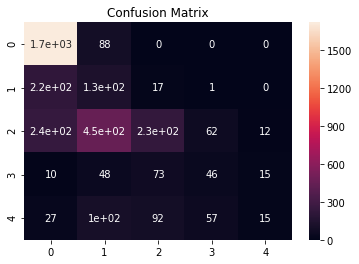

Validation loss decreased (0.892789 --> 0.882971).  Saving model ...
Epoch 6/39
----------


In [ ]:
#params
params = {
    "lr" : 1e-5,
    "batch_size" : 64,
    "n_epochs" : 20,
    "n_freeze" : 1,
    "num_workers" : 10,
    "coef" : [0.5, 1.5, 2.5, 3.5],
    "criterion" : nn.MSELoss(),
    "load_state" : False,
    "load_path" : None, 
    'save_path' : None,
    "device" : device,
    "n_folds" : 5,
    "early_stop" : True,
    "patience" : 3,
    "finetune" : False,
    "mixup_prob" : 0,
}

#training for the lazy, like me

# cv: new
if 0:
    params['finetune'] = True
    params['load_state'] = True
    #params['load_path'] =  "../input/mmmodel/model_old_test.bin" 
    params['load_path'] =  "../data/checkpoint/checkpoint.pt"
    Mytrain = train(params)
    Mytrain.get_train(RetinopathyDataset(csv_file="../input/aptos2019-blindness-detection/train.csv",
                                            transform=transform, datatype='train'))
    Mytrain.cv()

# train:old & valid:new
if 1:
    params['finetune'] = False
    params['mixup_prob'] = 0
    params['n_epochs'] = 40
    params['patience'] = 4
    params['save_path'] =  "model_ResNet50_old_mixup.bin"
    Mytrain = train(params)
    Mytrain.get_train(RetinopathyDataset(csv_file="../input/diabetic-retinopathy-resized/new_trainLabels.csv",
                                            transform=transform, datatype='train_old',mixup_prob=params['mixup_prob']))
    Mytrain.get_valid(RetinopathyDataset(csv_file="../input/aptos2019-blindness-detection/train.csv",
                                           transform=transform, datatype='train'))
    Mytrain.fit()
    
# train:new
if 0:
    params['finetune'] = True
    params['n_epochs'] = 3
    params['load_state'] = True
    #params['load_path'] =  "../input/mmmodel/model_insta_old.bin" 
    params['load_path'] =  "checkpoint.pt"
    params['save_path'] =  "model_ResNet50_old_mixup.bin"        
    Mytrain = train(params)
    Mytrain.get_train(RetinopathyDataset(csv_file="../input/aptos2019-blindness-detection/train.csv",
                                           transform=transform, datatype='train'))
    Mytrain.fit()

# Inference

In [ ]:
load_path = "../data/model/aptos19_ResNet101/model.bin"

model = load_model_instagram()
if torch.cuda.device_count() > 1:
    state_dict = torch.load(load_path)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
else:    
    model.load_state_dict(torch.load(load_path, map_location=self.device))

model = model.to(device)

model.eval()

In [ ]:
test_dataset = RetinopathyDataset(csv_file='../input/aptos2019-blindness-detection/sample_submission.csv',
                                      transform=transform, datatype='test')

In [ ]:
test_bs = 64
test_preds = np.zeros((len(test_dataset), 1))
TTA = 6
for _ in range(TTA):
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_bs, shuffle=False, num_workers=8)
    for i, x_batch in tqdm(enumerate(tqdm(test_data_loader))):
        x_batch = x_batch["image"]
        pred = model(x_batch.to(device))
        test_preds[i * test_bs:(i + 1) * test_bs] += pred.detach().cpu().squeeze().numpy().ravel().reshape(-1, 1)
test_preds /= TTA

In [ ]:
coef = [0.5, 1.5, 2.5, 3.5]

for i, pred in enumerate(test_preds):
    if pred < coef[0]:
        test_preds[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        test_preds[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        test_preds[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        test_preds[i] = 3
    else:
        test_preds[i] = 4


sample = pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")
sample.diagnosis = test_preds.astype(int)
sample.to_csv("submission.csv", index=False)

In [ ]:
sample["diagnosis"].value_counts()